## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
my_dir = '/content/drive/MyDrive/'
sys.path.insert(0,my_dir)

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [3]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TicTacToe_Env import TicTacToe
import collections
import numpy as np
from itertools import product
import random
import pickle
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
env = TicTacToe()

Convert state list to string key

In [5]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def create_state_key(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

Find valid actions for the agent at a particular state

In [6]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def agent_valid_actions(state):
    valid_actions = []
    valid_actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_actions


Add new state-action pairs to Q-dictionary for the state passed

In [7]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state_key = create_state_key(state)
    if state_key not in Q_dict.keys():
        valid_act = agent_valid_actions(state)
        for action in valid_act:
            Q_dict[state_key][action]= 0

### Epsilon-greedy strategy

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [8]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strateg
def action_epsilon_greedy(state,episodes,decay_rate):
    max_epsilon = 1.0
    min_epsilon = 0.001
    state_key = create_state_key(state)
    random_val = np.random.random()
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-1 * decay_rate * episodes)
    if random_val > epsilon:
      action = max(Q_dict[state_key], key=Q_dict[state_key].get)        
    else:
      #action = random.choice(agent_valid_actions(state)) 
      valid_actions = agent_valid_actions(state)
      action = valid_actions[np.random.choice(range(len(valid_actions)))]
    return action

### Tracking the state-action pairs for checking convergence

In [9]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [10]:
# Initialise states to be tracked
def initialise_tracking_states():
    '''state_action_pair = [('x-x-1-x-x-x-2-x-x',(0,5)), 
                        ('x-x-9-x-x-6-x-x-x',(7,7)),
                        ('x-1-6-x-x-x-x-x-x',(0,9)),
                        ('x-1-x-x-x-x-2-x-x',(2,3))]'''
    state_action_pair = [('x-x-x-x-x-x-x-x-x',(2,5)), #(1,9)
                        ('x-x-9-x-x-6-x-x-x',(7,7)),
                        ('x-1-6-x-x-x-x-x-x',(0,9)),
                        ('x-1-x-x-x-x-2-x-x',(2,3))]   
    for s, a in state_action_pair:
        States_track[s][a] = list()   
  

In [11]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [12]:
initialise_tracking_states()

In [13]:
States_track

defaultdict(dict,
            {'x-1-6-x-x-x-x-x-x': {(0, 9): []},
             'x-1-x-x-x-x-2-x-x': {(2, 3): []},
             'x-x-9-x-x-6-x-x-x': {(7, 7): []},
             'x-x-x-x-x-x-x-x-x': {(2, 5): []}})

In [14]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(my_dir + '/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Define hyperparameters

In [15]:
#define HP
EPISODES  = 5000000  #1000000            # total no. of episodes
decayRate = 0.000001 #0.000003         # Decay Rate                   
LR        = .01                      # learning rate
GAMMA = 0.9                   # discount factor

threshold = 2500 #1000             # no. of episodes after which states_tracked will be appended/saved
policy_threshold = 500000 #100000     # no of episodes after which Q dictionary will be updated/saved

### Epsilon Decay Check

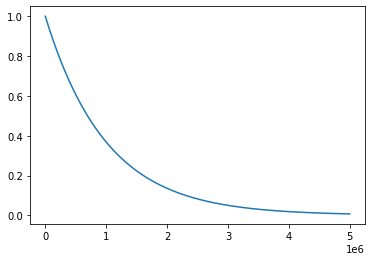

In [16]:
max_epsilon = 1.0
min_epsilon = 0.001
time_steps = np.arange(0,EPISODES)
epsilon = []
for i in range(len(time_steps)):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-1*decayRate*i))

plt.plot(time_steps, epsilon)
plt.show()

### Q-update loop

In [17]:
start_time = time.time()
agent_won = 0
env_won = 0
for episode in range(EPISODES):
    env = TicTacToe()
    current_state = env.state
    is_terminal = False
    add_to_dict(current_state)    
    #Play till a terminal state arrives
    while not is_terminal:
        current_state_key = create_state_key(current_state)
        agent_action = action_epsilon_greedy(current_state,episode,decayRate)
        reward,next_state,is_terminal = env.step(current_state,agent_action)
        if reward == 10:
          agent_won += 1
        elif reward == -10:
          env_won += 1 
        add_to_dict(next_state)
        next_state_key = create_state_key(next_state)
        if not is_terminal:
            #Q_dict[current_state_key][agent_action] += LR*(reward + GAMMA * max(Q_dict[next_state_key].values()) - Q_dict[current_state_key][agent_action])
            max_val_action = max(Q_dict[next_state_key], key=Q_dict[next_state_key].get)
            Q_dict[current_state_key][agent_action] += LR* ((reward + (GAMMA * (Q_dict[next_state_key][max_val_action]))) - Q_dict[current_state_key][agent_action])
        else:
            Q_dict[current_state_key][agent_action] += LR*(reward - Q_dict[current_state_key][agent_action])
        current_state = next_state        
    if (episode+1) % threshold == 0:
        save_tracking_states()
        save_obj(States_track,'States_tracked')
    if (episode+1) % policy_threshold == 0:
        print('Q-dictionary updated at episode: ',(episode+1))
        save_obj(Q_dict,'Policy')

elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')
save_obj(Q_dict,'Policy')

Q-dictionary updated at episode:  500000
Q-dictionary updated at episode:  1000000
Q-dictionary updated at episode:  1500000
Q-dictionary updated at episode:  2000000
Q-dictionary updated at episode:  2500000
Q-dictionary updated at episode:  3000000
Q-dictionary updated at episode:  3500000
Q-dictionary updated at episode:  4000000
Q-dictionary updated at episode:  4500000
Q-dictionary updated at episode:  5000000


In [18]:
print('Total training time: ' + str(elapsed_time/60) + 'mins.')
print('Total games won by the environment: ', env_won)
print('Total games won by the agent: ', agent_won)

Total training time: 52.63190802335739mins.
Total games won by the environment:  550679
Total games won by the agent:  3533902


#### Check the Q-dictionary

In [19]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.2726868567728131,
              (0, 3): -1.1734668928649516,
              (0, 5): -1.0265717161292132,
              (0, 7): -1.3349754672743894,
              (0, 9): -1.2775040702043157,
              (1, 1): -1.2685663871061226,
              (1, 3): -1.2965058456109602,
              (1, 5): -1.3346419805044953,
              (1, 7): -1.3467352397695145,
              (1, 9): -1.2660652033539546,
              (2, 1): -1.345615429554298,
              (2, 3): -0.6654499284015588,
              (2, 5): -1.3409497866916358,
              (2, 7): -1.3046441792293255,
              (2, 9): -1.3182139838468545,
              (3, 1): -1.2989379841291764,
              (3, 3): 0.6883327141520128,
              (3, 5): -1.2021233914313088,
              (3, 7): -1.2864148295087106,
              (3, 9): -1.26409853078556,
              (4, 1): -1.3797221141619083,
              (4, 3): -1.3041583717016343,
              (4, 5

In [20]:
len(Q_dict)

2288477

#### Checking the total tracked values against each tracked state

In [21]:
state_action_occ = collections.defaultdict(dict)

for state in States_track.keys():
    for action in States_track[state].keys():   
        state_action_occ[state][action] = len(States_track[state][action])
            
state_action_occ


defaultdict(dict,
            {'x-1-6-x-x-x-x-x-x': {(0, 9): 2000},
             'x-1-x-x-x-x-2-x-x': {(2, 3): 2000},
             'x-x-9-x-x-6-x-x-x': {(7, 7): 2000},
             'x-x-x-x-x-x-x-x-x': {(2, 5): 2000}})

#### Checking one of the state in the Q dictionary

In [22]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
key = 'x-x-9-x-x-6-x-x-x'
valueAgainstKey = Q_dict[key]
print(valueAgainstKey)

{(0, 1): -0.37352542286602775, (0, 3): -0.3738633549638898, (0, 5): -0.37255738008272393, (0, 7): -0.3706661616384129, (1, 1): -0.3702836034686744, (1, 3): -0.3723872352342391, (1, 5): -0.3755085595105788, (1, 7): -0.3722964137260694, (3, 1): -0.38387921500043054, (3, 3): -0.3764746051087998, (3, 5): -0.3800530585913198, (3, 7): -0.3764746051087998, (4, 1): -0.42255445080464826, (4, 3): -0.3764746051087998, (4, 5): -0.44372317448165455, (4, 7): -0.3750358772187076, (6, 1): -0.3704760418087032, (6, 3): -0.3761289602864702, (6, 5): -0.37096963722752585, (6, 7): -0.3703554687967675, (7, 1): -0.3731071856566557, (7, 3): -0.3727980194330299, (7, 5): -0.3765610587496998, (7, 7): -0.3764746051087998, (8, 1): -0.37418736299759114, (8, 3): -0.37294391408017713, (8, 5): -0.37555986569560745, (8, 7): -0.37313595675377254}


In [23]:
tuples_sorted = sorted(valueAgainstKey.items(), key=lambda x:x[1], reverse=True)
dict_sorted = {key:value for key, value in tuples_sorted}
print(dict_sorted)

{(1, 1): -0.3702836034686744, (6, 7): -0.3703554687967675, (6, 1): -0.3704760418087032, (0, 7): -0.3706661616384129, (6, 5): -0.37096963722752585, (1, 7): -0.3722964137260694, (1, 3): -0.3723872352342391, (0, 5): -0.37255738008272393, (7, 3): -0.3727980194330299, (8, 3): -0.37294391408017713, (7, 1): -0.3731071856566557, (8, 7): -0.37313595675377254, (0, 1): -0.37352542286602775, (0, 3): -0.3738633549638898, (8, 1): -0.37418736299759114, (4, 7): -0.3750358772187076, (1, 5): -0.3755085595105788, (8, 5): -0.37555986569560745, (6, 3): -0.3761289602864702, (3, 3): -0.3764746051087998, (3, 7): -0.3764746051087998, (4, 3): -0.3764746051087998, (7, 7): -0.3764746051087998, (7, 5): -0.3765610587496998, (3, 5): -0.3800530585913198, (3, 1): -0.38387921500043054, (4, 1): -0.42255445080464826, (4, 5): -0.44372317448165455}


#### Check the states tracked for Q-values convergence
(non-evaluative)

<function matplotlib.pyplot.show>

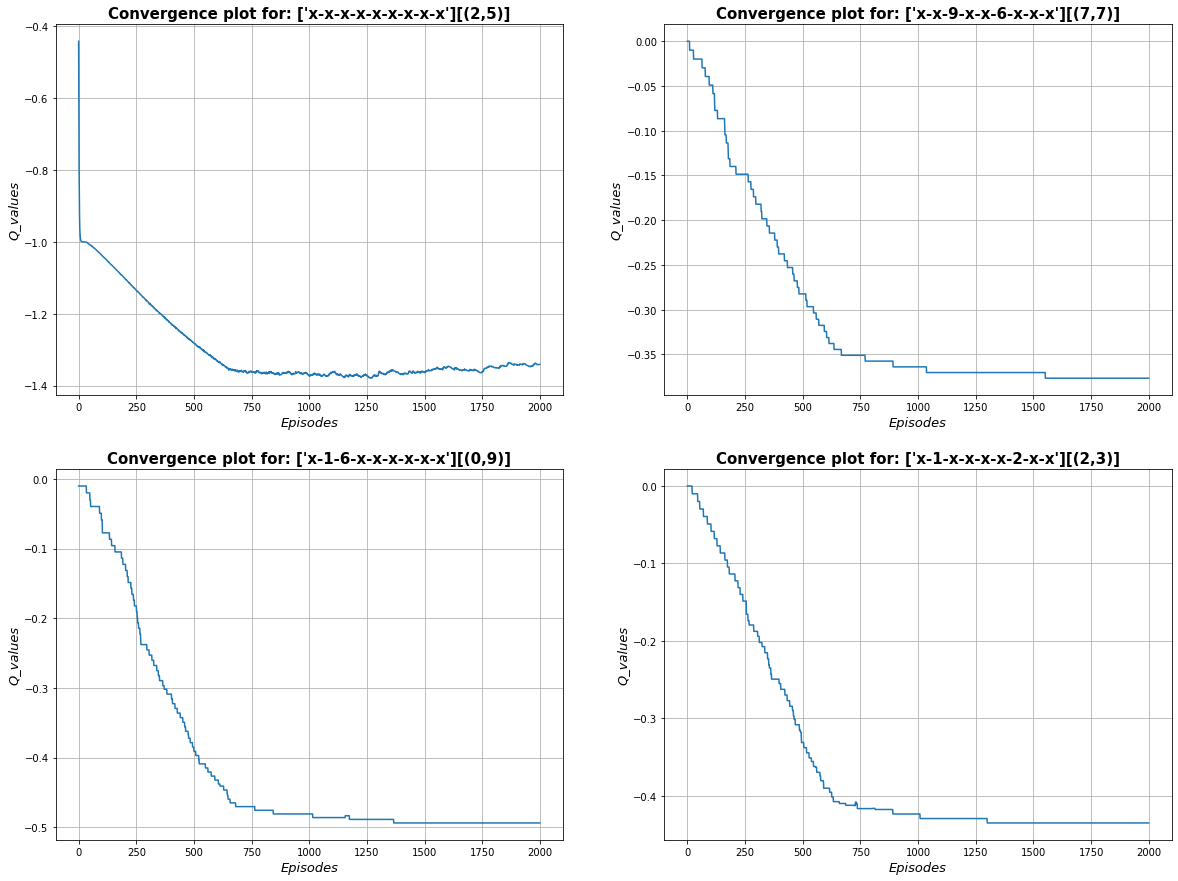

In [24]:
# Write the code for plotting the graphs for state-action pairs tracked
plt.figure(0, figsize=(20,15))

#Convergence Plot for state-action pair: ['x-x-x-x-x-x-x-x-x'][(2,5)]
x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(2,5)])))
plt.subplot(2,2,1)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(2,5)]))
plt.title("Convergence plot for: ['x-x-x-x-x-x-x-x-x'][(2,5)]", fontsize=15, fontweight='bold')
plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
plt.xlabel("Episodes", fontsize=13, fontstyle='italic')
plt.grid(True)
plt.show

#Convergence Plot for state-action pair: ['x-x-9-x-x-6-x-x-x'][(7,7)]
x_axis = np.asarray(range(0, len(States_track['x-x-9-x-x-6-x-x-x'][(7,7)])))
plt.subplot(2,2,2)
plt.plot(x_axis,np.asarray(States_track['x-x-9-x-x-6-x-x-x'][(7,7)]))
plt.title("Convergence plot for: ['x-x-9-x-x-6-x-x-x'][(7,7)]", fontsize=15, fontweight='bold')
plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
plt.xlabel("Episodes", fontsize=13, fontstyle='italic')
plt.grid(True)
plt.show

#Convergence Plot for state-action pair: ['x-1-6-x-x-x-x-x-x'][(0,9)]
x_axis = np.asarray(range(0, len(States_track['x-1-6-x-x-x-x-x-x'][(0,9)])))
plt.subplot(2,2,3)
plt.plot(x_axis,np.asarray(States_track['x-1-6-x-x-x-x-x-x'][(0,9)]))
plt.title("Convergence plot for: ['x-1-6-x-x-x-x-x-x'][(0,9)]", fontsize=15, fontweight='bold')
plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
plt.xlabel("Episodes", fontsize=13, fontstyle='italic')
plt.grid(True)
plt.show

#Convergence Plot for state-action pair: ['x-1-x-x-x-x-2-x-x'][(2,3)]
x_axis = np.asarray(range(0, len(States_track['x-1-x-x-x-x-2-x-x'][(2,3)])))
plt.subplot(2,2,4)
plt.plot(x_axis,np.asarray(States_track['x-1-x-x-x-x-2-x-x'][(2,3)]))
plt.title("Convergence plot for: ['x-1-x-x-x-x-2-x-x'][(2,3)]", fontsize=15, fontweight='bold')
plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
plt.xlabel("Episodes", fontsize=13, fontstyle='italic')
plt.grid(True)
plt.show